# Rejection ABC
This example shows you how to perform Rejection ABC on a time series from the stochastic degradation model.


First, the stochastic degradation model needs to be loaded.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

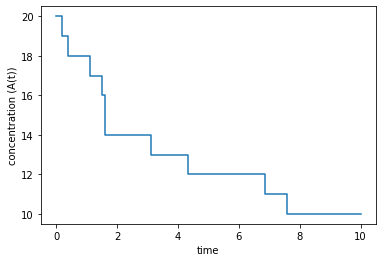

In [2]:
np.random.seed(3)

# Load a forward model
model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

plt.step(times, values)
plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using Rejection ABC

Now the Rejection ABC algorithm can be applied to sample parameter values.

In [3]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(200)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     91     0.010989011      0:00.1
2     317    0.00630914826    0:00.2
3     1023   0.00293255132    0:00.4
20    3841   0.00520697735    0:01.3
40    6299   0.00635021432    0:01.9
60    8010   0.0074906367     0:02.4
80    10140  0.00788954635    0:02.9
100   12195  0.008200082      0:03.6
120   15140  0.00792602378    0:04.4
140   17443  0.00802614229    0:05.0
160   20806  0.0076900894     0:05.9
180   22634  0.00795263762    0:06.3
200   25295  0.00790670093    0:07.1
Halting: target number of samples (200) reached.
Done


Plotting the approximate posterior compared to the actual parameter value.

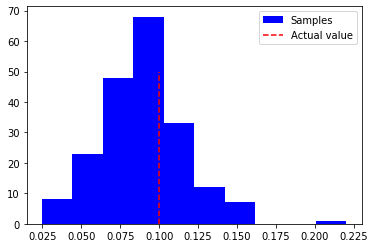

In [4]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50, label="Actual value", color="red")
plt.legend()
plt.show()

# Note on Rejection ABC

The Rejection ABC algorithm is a highly simplistic method for Bayesian inference. As a consequence, it is inefficient when used with high variance priors.

Please make sure that you are monitoring the acceptance rate to see if this algorithm is working for your problem.